TASK I

In [1]:
#You may skip this step if you wanna save some time.
#To download the entire data sets we copy and paste the section "Download" in https://www.kaggle.com/datasets/cnrieiit/mqttset/data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cnrieiit/mqttset")

print("Path to dataset files:", path)

Path to dataset files: /home/samuelgiovanetti99/.cache/kagglehub/datasets/cnrieiit/mqttset/versions/5


In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext
from pyspark.sql.functions import lit
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import avg
from pyspark.sql.functions import count
from pyspark.sql.functions import max
from pyspark.sql.functions import collect_list
from pyspark.sql.functions import explode
import matplotlib.pyplot as plt
import os
import torch

In [2]:
import os
import shutil
import logging

os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-17-openjdk-amd64'

logging.getLogger("org.apache.spark").setLevel(logging.ERROR)
logging.getLogger("org.apache.hadoop").setLevel(logging.ERROR)
logging.getLogger("streaming").setLevel(logging.ERROR)
logging.getLogger("xgboost").setLevel(logging.ERROR)
logging.getLogger("xgboost.spark").setLevel(logging.ERROR)
logging.getLogger("distributed").setLevel(logging.ERROR)

os.makedirs("/mnt/new-ssd/", exist_ok=True)

spark = SparkSession.builder \
    .appName("Project2") \
    .master("local[32]") \
    .config("spark.driver.memory", "45g") \
    .config("spark.driver.maxResultSize", "12g") \
    .config("spark.executor.cores", "32") \
    .config("spark.executor.memory", "45g") \
    .config("spark.memory.fraction", "0.80") \
    .config("spark.memory.storageFraction", "0.35") \
    .config("spark.memory.offHeap.enabled", "false") \
    .config("spark.sql.shuffle.partitions", "96") \
    .config("spark.default.parallelism", "96") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.adaptive.skewJoin.enabled", "true") \
    .config("spark.sql.adaptive.advisoryPartitionSizeInBytes", "128m") \
    .config("spark.local.dir", "/mnt/new-ssd/spark-tmp") \
    .config("spark.io.compression.codec", "lz4") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryo.registrationRequired", "false") \
    .config("spark.rpc.message.maxSize", 512) \
    .config("spark.task.maxFailures", "3") \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "30s") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/13 04:54:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/11/13 04:54:29 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
df_train = spark.read.csv("./train70_augmented.csv",header=True, inferSchema= True)
df_test = spark.read.csv("./test30_augmented.csv",header=True, inferSchema= True)

In [7]:
df_train.show(5)
df_train.printSchema()

+----------+--------------+-------+-----------------+--------------------------+--------------------+---------------+----------------------+-------------------+----------------+---------------------+-------------------+------------------+---------------------+-------------+------------+-------------+-----------+--------+--------+----------+------------+--------------+--------------+--------+-----------+------------+---------------+--------+------------+----------------+--------------+------------------+----------+
| tcp.flags|tcp.time_delta|tcp.len|mqtt.conack.flags|mqtt.conack.flags.reserved|mqtt.conack.flags.sp|mqtt.conack.val|mqtt.conflag.cleansess|mqtt.conflag.passwd|mqtt.conflag.qos|mqtt.conflag.reserved|mqtt.conflag.retain|mqtt.conflag.uname|mqtt.conflag.willflag|mqtt.conflags|mqtt.dupflag|mqtt.hdrflags|mqtt.kalive|mqtt.len|mqtt.msg|mqtt.msgid|mqtt.msgtype|mqtt.proto_len|mqtt.protoname|mqtt.qos|mqtt.retain|mqtt.sub.qos|mqtt.suback.qos|mqtt.ver|mqtt.willmsg|mqtt.willmsg_len|mqtt.w

In [8]:
df_train = df_train.withColumn("dataset", lit("train"))
df_test = df_test.withColumn("dataset", lit("test"))

df = df_train.union(df_test) #merge the 2 dfs

df = df.withColumn("id", monotonically_increasing_id()) #add unique identifier

In [9]:
print(df.count())
df.printSchema()

[Stage 6:=====================================>                (133 + 33) / 192]

20000000
root
 |-- tcp.flags: string (nullable = true)
 |-- tcp.time_delta: double (nullable = true)
 |-- tcp.len: integer (nullable = true)
 |-- mqtt.conack.flags: string (nullable = true)
 |-- mqtt.conack.flags.reserved: double (nullable = true)
 |-- mqtt.conack.flags.sp: double (nullable = true)
 |-- mqtt.conack.val: double (nullable = true)
 |-- mqtt.conflag.cleansess: double (nullable = true)
 |-- mqtt.conflag.passwd: double (nullable = true)
 |-- mqtt.conflag.qos: double (nullable = true)
 |-- mqtt.conflag.reserved: double (nullable = true)
 |-- mqtt.conflag.retain: double (nullable = true)
 |-- mqtt.conflag.uname: double (nullable = true)
 |-- mqtt.conflag.willflag: double (nullable = true)
 |-- mqtt.conflags: string (nullable = true)
 |-- mqtt.dupflag: double (nullable = true)
 |-- mqtt.hdrflags: string (nullable = true)
 |-- mqtt.kalive: double (nullable = true)
 |-- mqtt.len: double (nullable = true)
 |-- mqtt.msg: string (nullable = true)
 |-- mqtt.msgid: double (nullable = 

In [10]:
#Update based on your properties
db_properties = {}
db_properties['username'] = "sgiovane"
db_properties['password'] = "Toolchain2025"
db_properties['url'] = "jdbc:postgresql://localhost:5432/mqtt"
db_properties['table'] = "mqtt.augmented"
db_properties['driver'] = "org.postgresql.Driver"

In [11]:
df.write.format("jdbc") \
    .mode("overwrite") \
    .option("url", db_properties['url']) \
    .option("dbtable", db_properties['table']) \
    .option("user", db_properties['username']) \
    .option("password", db_properties['password']) \
    .option("driver", db_properties['driver']) \
    .save()


In [12]:
df_read = spark.read.format("jdbc") \
    .option("url", db_properties['url']) \
    .option("dbtable", db_properties['table']) \
    .option("user", db_properties['username']) \
    .option("password", db_properties['password']) \
    .option("driver", db_properties['driver']) \
    .option("numPartitions", 32) \
    .option("partitionColumn", "id") \
    .option("lowerBound", 1) \
    .option("upperBound", 20000000) \
    .option("fetchsize", 50000) \
    .load() \
    .cache()

#after 10 minutes of reading I was not done. Therfore, I looked for ways to explot the parallelisation potential of Spark to fetch the data. 
#the partition part of the code comes from https://spark.apache.org/docs/latest/sql-data-sources-jdbc.html
#The right proportion of paritions and fetchsize, comes from a discussion with ChatGPT

df_read.show(1, vertical=True)

[Stage 10:======================================================> (31 + 1) / 32]

-RECORD 0--------------------------------
 tcp.flags                  | 0x00000018 
 tcp.time_delta             | 1.000039   
 tcp.len                    | 13         
 mqtt.conack.flags          | 0          
 mqtt.conack.flags.reserved | 0.0        
 mqtt.conack.flags.sp       | 0.0        
 mqtt.conack.val            | 0.0        
 mqtt.conflag.cleansess     | 0.0        
 mqtt.conflag.passwd        | 0.0        
 mqtt.conflag.qos           | 0.0        
 mqtt.conflag.reserved      | 0.0        
 mqtt.conflag.retain        | 0.0        
 mqtt.conflag.uname         | 0.0        
 mqtt.conflag.willflag      | 0.0        
 mqtt.conflags              | 0          
 mqtt.dupflag               | 0.0        
 mqtt.hdrflags              | 0x00000030 
 mqtt.kalive                | 0.0        
 mqtt.len                   | 11.0       
 mqtt.msg                   | 32         
 mqtt.msgid                 | 0.0        
 mqtt.msgtype               | 3.0        
 mqtt.proto_len             | 0.0 

In [13]:
df_read.show(5)
df_read.printSchema()

+----------+--------------+-------+-----------------+--------------------------+--------------------+---------------+----------------------+-------------------+----------------+---------------------+-------------------+------------------+---------------------+-------------+------------+-------------+-----------+--------+--------+----------+------------+--------------+--------------+--------+-----------+------------+---------------+--------+------------+----------------+--------------+------------------+----------+-------+---+
| tcp.flags|tcp.time_delta|tcp.len|mqtt.conack.flags|mqtt.conack.flags.reserved|mqtt.conack.flags.sp|mqtt.conack.val|mqtt.conflag.cleansess|mqtt.conflag.passwd|mqtt.conflag.qos|mqtt.conflag.reserved|mqtt.conflag.retain|mqtt.conflag.uname|mqtt.conflag.willflag|mqtt.conflags|mqtt.dupflag|mqtt.hdrflags|mqtt.kalive|mqtt.len|mqtt.msg|mqtt.msgid|mqtt.msgtype|mqtt.proto_len|mqtt.protoname|mqtt.qos|mqtt.retain|mqtt.sub.qos|mqtt.suback.qos|mqtt.ver|mqtt.willmsg|mqtt.willms

TAKS II

In [14]:
#1
def avg_len_MQTT(dataset, target):
    if dataset != "train" and dataset != "test":
        return "Error"

    if target != "slowite" and target != "bruteforce" and target != "dos" and target != "flood" and target != "malformed" and target != "legitimate":
        return "Error"

    df_sub = df_read.filter(df_read["dataset"] == dataset)
    df_sub = df_sub.filter(df_read["target"] == target)

    df_sub = df_sub.groupBy("target")
    df_sub = df_sub.agg(avg("`mqtt.len`"))
    df_sub.show()

avg_len_MQTT("test", "slowite")
avg_len_MQTT("train", "slowite")

+-------+---------------+
| target|avg(`mqtt.len`)|
+-------+---------------+
|slowite|        3.27525|
+-------+---------------+



[Stage 16:======================================================> (31 + 1) / 32]

+-------+---------------+
| target|avg(`mqtt.len`)|
+-------+---------------+
|slowite|        3.27525|
+-------+---------------+



In [15]:
#2
def len_pop_tcp():

    #we first find the average tcp len for each target
    df_sub = df_read.groupBy("target")
    df_avg = df_sub.agg(avg("`tcp.len`")) 

    #we group by target and flag, and count the flag 
    df_pop = df_read.groupBy("target", "`mqtt.hdrflags`")
    df_pop = df_pop.agg(count("*").alias("count"))
    #we regroup by target with the max count flag found and then we perform a join based on the max value for each target
    df_max = df_pop.groupBy("target").agg(max(df_pop["count"]).alias("m"))
    df_pop = df_pop.join(df_max, on="target").filter(df_pop["count"] == df_max["m"]).drop("m").drop("count")

    #finally we join the tcp len averages with the max count, on the targets
    df_pop = df_pop.join(df_avg, on="target")

    df_pop.show()

len_pop_tcp()

[Stage 19:===============>(31 + 1) / 32][Stage 20:===============>(31 + 1) / 32]

+----------+-------------+--------------+
|    target|mqtt.hdrflags|avg(`tcp.len`)|
+----------+-------------+--------------+
|   slowite|            0|         3.702|
| malformed|            0|       21.3381|
|     flood|            0|     13487.218|
|legitimate|   0x00000030|     7.7844068|
|bruteforce|            0|       3.25358|
|       dos|   0x00000040|   312.2267835|
+----------+-------------+--------------+



In [16]:
#3
def most_frequent_TCP(X, Y):
    #first we check whether the input is valid
    if X<0:
        return "Error"

    if Y < 0.0 or Y > 5.0:
        return "Error"

    #we filter the dataframe based on the time delta and then we group by the flags, counting the number of occurences
    df_sub = df_read.filter(df_read["`tcp.time_delta`"] <= Y)
    df_sub = df_sub.groupBy("`tcp.flags`").agg(count("*").alias("count"))
    
    #here the idea is to group by count and take all the flags for the first X counts. This is done to include the most frequent flags also in case there are ties
    #we use collect list to get multiple flags for the same count https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.collect_list.html
    df_sub = df_sub.groupBy("count").agg(collect_list("`tcp.flags`").alias("f"))
    df_sub = df_sub.orderBy(df_sub["count"].desc())

    #we limit the dataframe to the first X counts so that we have onlythe most frequent flags
    df_sub = df_sub.limit(X)
    #we explode the aggregated list to have each value on a different line https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.explode.html
    df_sub = df_sub.select(df_sub["count"], explode(df_sub["f"]).alias("tcp.flags")).drop("count")

    df_sub.show()

most_frequent_TCP(5,3.0)

[Stage 31:======================================================> (31 + 1) / 32]

+----------+
| tcp.flags|
+----------+
|0x00000018|
|0x00000010|
|0x00000002|
|0x00000012|
|0x00000011|
+----------+



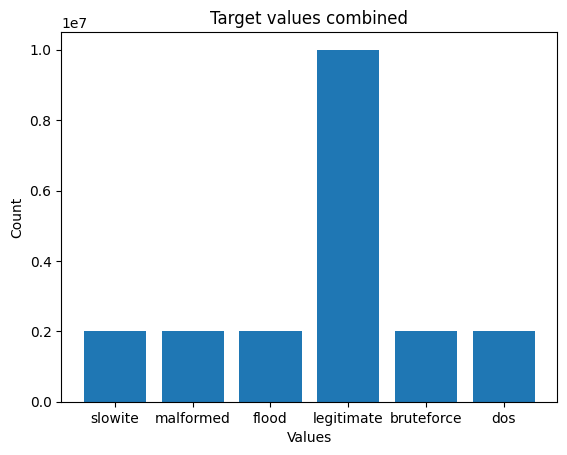

In [17]:
#4
def histo(dataset):
    #assuming the exercise requires to plot the NUMBER of target values
    if dataset == "train" or dataset == "test":
        df_sub = df_read.filter(df_read["dataset"] == dataset)
        df_sub = df_sub.groupBy("target").agg(count("*").alias("count"))

        #I learnt about toPandas() here: https://stackoverflow.com/questions/36043256/making-histogram-with-spark-dataframe-column
        pdf = df_sub.toPandas() 
        plt.bar(pdf["target"], pdf["count"])
        plt.title("Target values " + dataset)
        plt.xlabel("Values")
        plt.ylabel("Count")

    elif dataset == "combined":
        #I learnt about toPandas() here: https://stackoverflow.com/questions/36043256/making-histogram-with-spark-dataframe-column
        df_sub = df_read.groupBy("target").agg(count("*").alias("count"))

        pdf = df_sub.toPandas() 
        plt.bar(pdf["target"], pdf["count"])
        plt.title("Target values combined")
        plt.xlabel("Values")
        plt.ylabel("Count")

    else:
        return "Error"

#histo("test")
#histo("train")
histo("combined")

In [16]:
#5
words = ["brute force", "slow it", "DoS", "flood", "malformed", "legitimate"]

In [45]:
#Producer
#!pip install confluent_kafka google-api-python-client streamlit

import socket
from confluent_kafka import Producer, KafkaError
import os
import time 
from googleapiclient.discovery import build
import json
from datetime import datetime, timedelta

# Kafka settings
BROKER = 'localhost:9092'
TOPIC = 'Project2'
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="cmu-class.json"
youtube = build('youtube', 'v3')


def get_comments(video_id):
    request = youtube.commentThreads().list(
        part='snippet',
        videoId=video_id,
        textFormat='plainText',
        maxResults=100
    )
    response = request.execute()
    print(f"Video ID: {video_id}, items: {len(response.get('items', []))}")
    comments = []
    for item in response['items']:
        print(item)
        comment = item['snippet']['topLevelComment']['snippet']
        comment_data = {
            'author': comment['authorDisplayName'],
            'text': comment['textDisplay'],
        }
        comments.append(comment_data)

    return comments

# Function to create a Kafka consumer
def create_kafka_producer(broker):
    conf = {
        'bootstrap.servers': broker,
        'client.id': socket.gethostname()

    }
    producer = Producer(conf)
    return producer

def get_videos():
    keywords = ["cybersecurity", "network security", "attack"]
    
    comments = []
    for k in keywords:
        #for each keyword we get the comments of the last 5 minutes feed, https://developers.google.com/youtube/v3/docs/search/list
        request = youtube.search().list(
            part='snippet',
            type='video',
            order='date',
            q=k, 
            publishedAfter= (datetime.now() - timedelta(minutes=5)).strftime("%Y-%m-%dT%H:%M:%SZ"), #last 5 minutes video do not have comments
            maxResults=50,
        )
        response = request.execute()

        for item in response['items']:
            try:
                c = get_comments(item['id']['videoId'])
                #print(item['id']['videoId'])
                print(c)
                comments.extend(c)
            except Exception:
                continue

    return comments

def stream_youtube_comments():
    seen_comments = set()
    producer = create_kafka_producer(BROKER)

    comments = get_videos()   
    print(comments)  
    for comment in comments:
        comment_id = comment['author'] + comment['text']
        if comment_id not in seen_comments:
            seen_comments.add(comment_id)
            # Send new comment to Kafka
            producer.produce(TOPIC, key=str(comment['author']), value=str(comment['text']))
            producer.flush()

if __name__ == "__main__":
    stream_youtube_comments()

Video ID: BSsaStbNfL0, items: 0
[]
Video ID: 3hcQYHCGEqI, items: 0
[]
Video ID: Bg4h0gHbN5Q, items: 0
[]
Video ID: FYQ1dPNq0nQ, items: 0
[]
Video ID: jZBMIMOLfRo, items: 0
[]
Video ID: lv4VUFCFI6c, items: 0
[]
Video ID: LvxHnR2RdeQ, items: 3
{'kind': 'youtube#commentThread', 'etag': 'w2RnoyAc0vV4iKRKBPvGzWN4JfA', 'id': 'Ugycg9N1rj99mnYMf0d4AaABAg', 'snippet': {'channelId': 'UCsmbGlndatzeBl-Mw5VROOw', 'videoId': 'LvxHnR2RdeQ', 'topLevelComment': {'kind': 'youtube#comment', 'etag': 'bOg4KxwP7HGhABjiidtYP40PicU', 'id': 'Ugycg9N1rj99mnYMf0d4AaABAg', 'snippet': {'channelId': 'UCsmbGlndatzeBl-Mw5VROOw', 'videoId': 'LvxHnR2RdeQ', 'textDisplay': 'تم', 'textOriginal': 'تم', 'authorDisplayName': '@BenEissa-xw2tm', 'authorProfileImageUrl': 'https://yt3.ggpht.com/ytc/AIdro_nYQvAmUyrYtkF2soc7ppz6IxaER9_xGSrVZLHiG4eUGMeY1Tl-U5nqn34h_UtOew4GdA=s48-c-k-c0x00ffffff-no-rj', 'authorChannelUrl': 'http://www.youtube.com/@BenEissa-xw2tm', 'authorChannelId': {'value': 'UCBNyG8_eKfRb-J1zPczCGcg'}, 'canRate': 

In [46]:
from confluent_kafka import Consumer, KafkaError
import socket
from collections import defaultdict

# Kafka settings
BROKER = 'localhost:9092'  # Change this to your Kafka broker address
GROUP_ID = 'project2'
TOPIC = 'Project2'

# Function to create a Kafka consumer
def create_kafka_consumer(broker, group_id, topic):
    conf = {
        'bootstrap.servers': broker,
        'group.id': group_id,
        'auto.offset.reset': 'earliest',
        'client.id': socket.gethostname()
    }
    consumer = Consumer(conf)
    consumer.subscribe([topic])
    return consumer

# Display data from Kafka
def display_kafka_data():
    consumer = create_kafka_consumer(BROKER, GROUP_ID, TOPIC)    
    print("Listening to Kafka topic:", TOPIC)

    counts = defaultdict(int) 
    comments = []

    word_mapping = {
        "brute force": ["brute force", "bruteforce", "brute-force", "brute", "dictionary attack", "password attack"],
        "slow it": ["slow it", "slowit", "slow-it", "slowdown", "slow down", "lag", "performance"],
        "dos": ["dos", "ddos", "d-dos", "denial", "denial of service"],
        "flood": ["flood", "flooded", "flooding", "packet flood", "syn flood"],
        "malformed": ["malformed", "mal-formed", "corrupted", "corrupt", "invalid"],
        "legitimate": ["legitimate", "legit", "clean", "normal", "benign"]
    }

    while True:
        msg = consumer.poll(timeout=1.0)       
        if msg is None:
            break
        if msg.error():
            if msg.error().code() == KafkaError._PARTITION_EOF:
                continue
            else:
                print.error(msg.error())
                break
        
        key = msg.key().decode('utf-8')
        value = msg.value().decode('utf-8')
        print(value)
        comments.append(value)

        singles = value.lower().split() #get the list of words in the comment string

        for c, variants in word_mapping.items():
            #the following division is to avoid counting words that are subwords of other words
            for w in variants:
                if " " in w: #for the case brute force and slow it
                    counts[c] += value.lower().count(w)
                else:
                    counts[c] += singles.count(w)
        

    consumer.close()
    print("Comments analized: " + str(len(comments)))
    print(counts)
    max_word = __builtins__.max(counts, key=counts.get)
    #print(max_word)
    return [max_word, counts[max_word]]
        

if __name__ == "__main__":
    # Streamlit app title
    print("Kafka Streamlit Consumer")
    arr = display_kafka_data()
    print("\nMost frequent word among the targets: "+str(arr[0])+", which appeared "+str(arr[1]) +" times")

Kafka Streamlit Consumer
Listening to Kafka topic: Project2
تم
ما شاءالله. حلمي usb رابر دكي. إن شاء الله كون من الفائزين.
تم
Bhayya ne girlfriend Instagram Ela hack cheyalo cheppava
💡 Thanks for watching! This video is part of our FREE Small Business Cybersecurity Course → https://guardianangelit.com/small-business-cybersecurity/

👉 Question for you: What’s the biggest cybersecurity advantage you think your business has right now? Drop your answer below — I’d love to hear it!

👍 Like this video & 🔔 Subscribe to get more practical, no-fluff cybersecurity tips for small businesses.
Congratulations  super mom🙏🏾🎉🎉🎉🎉
Congratulations!
So proud of you and happy for your accomplishments.  Love your affirmations.  You are an awesome person and mother. May God continue to bless you in all you do.
Congrats Shyvonne 🎉 keep up the good work. You looked sooooooo pretty.  I loved your makeup & your outfit.  You go girl
Congratulations again to you  been a subscriber for years watching you has inspir

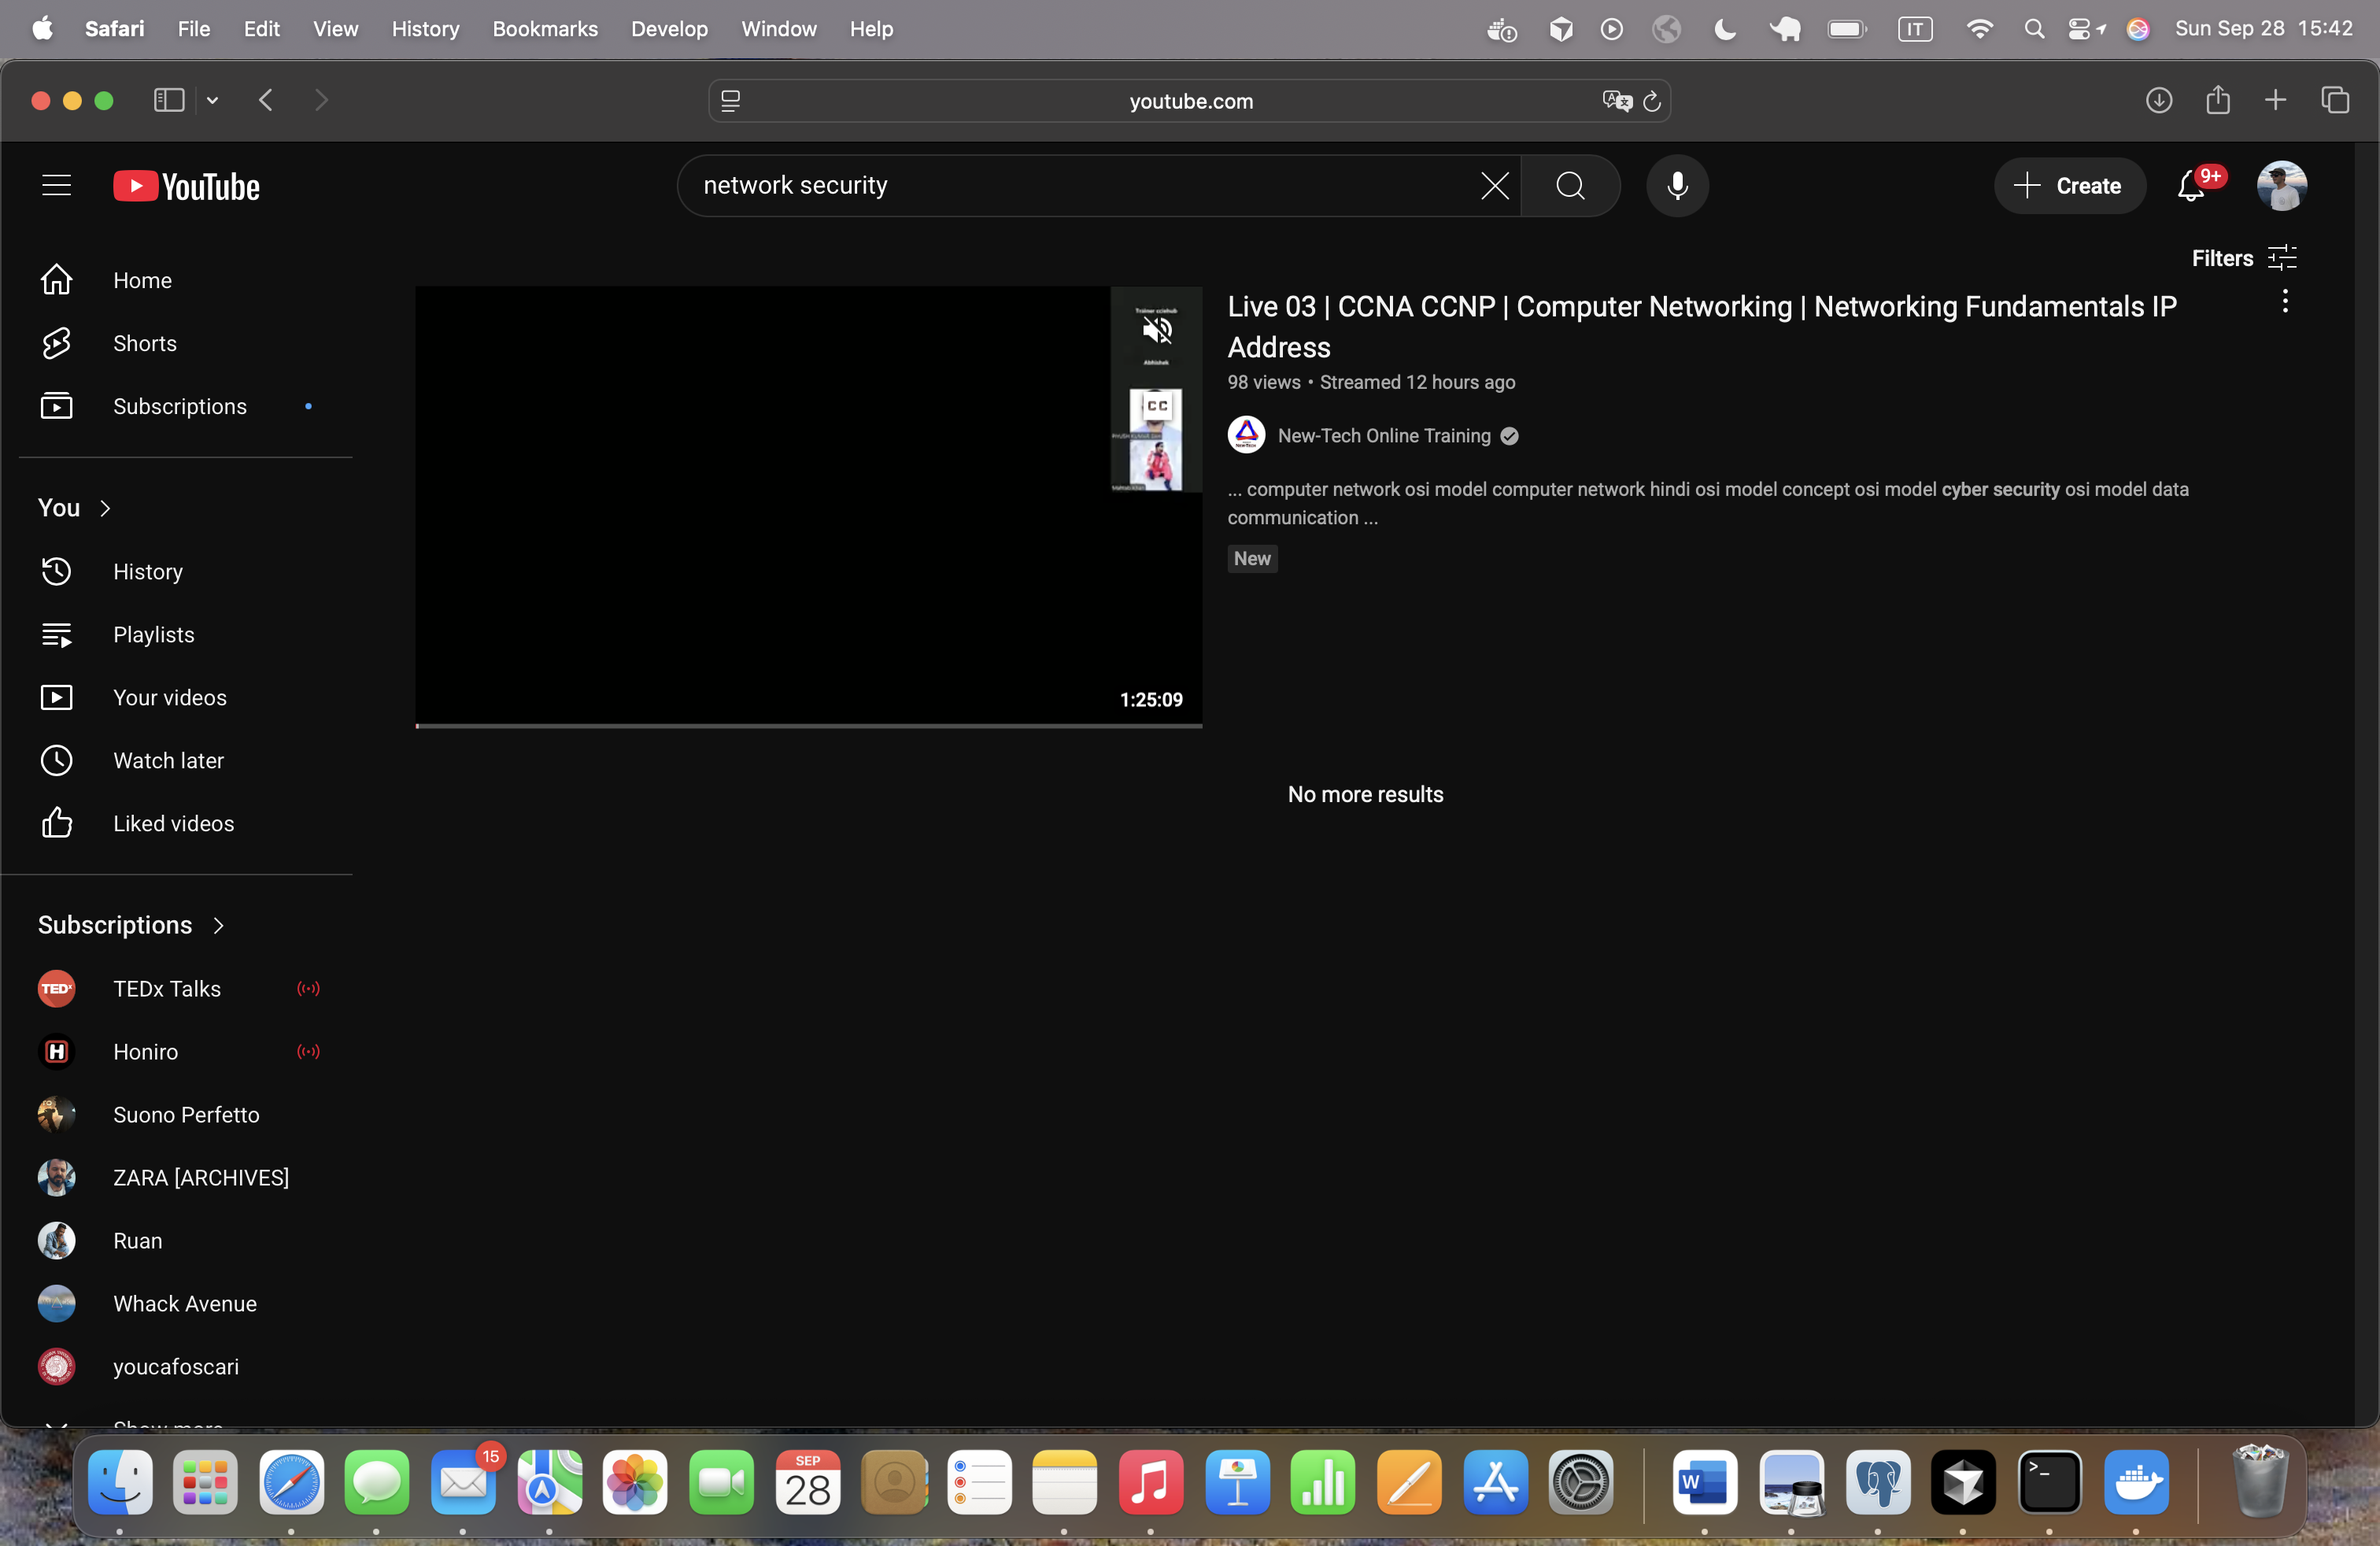
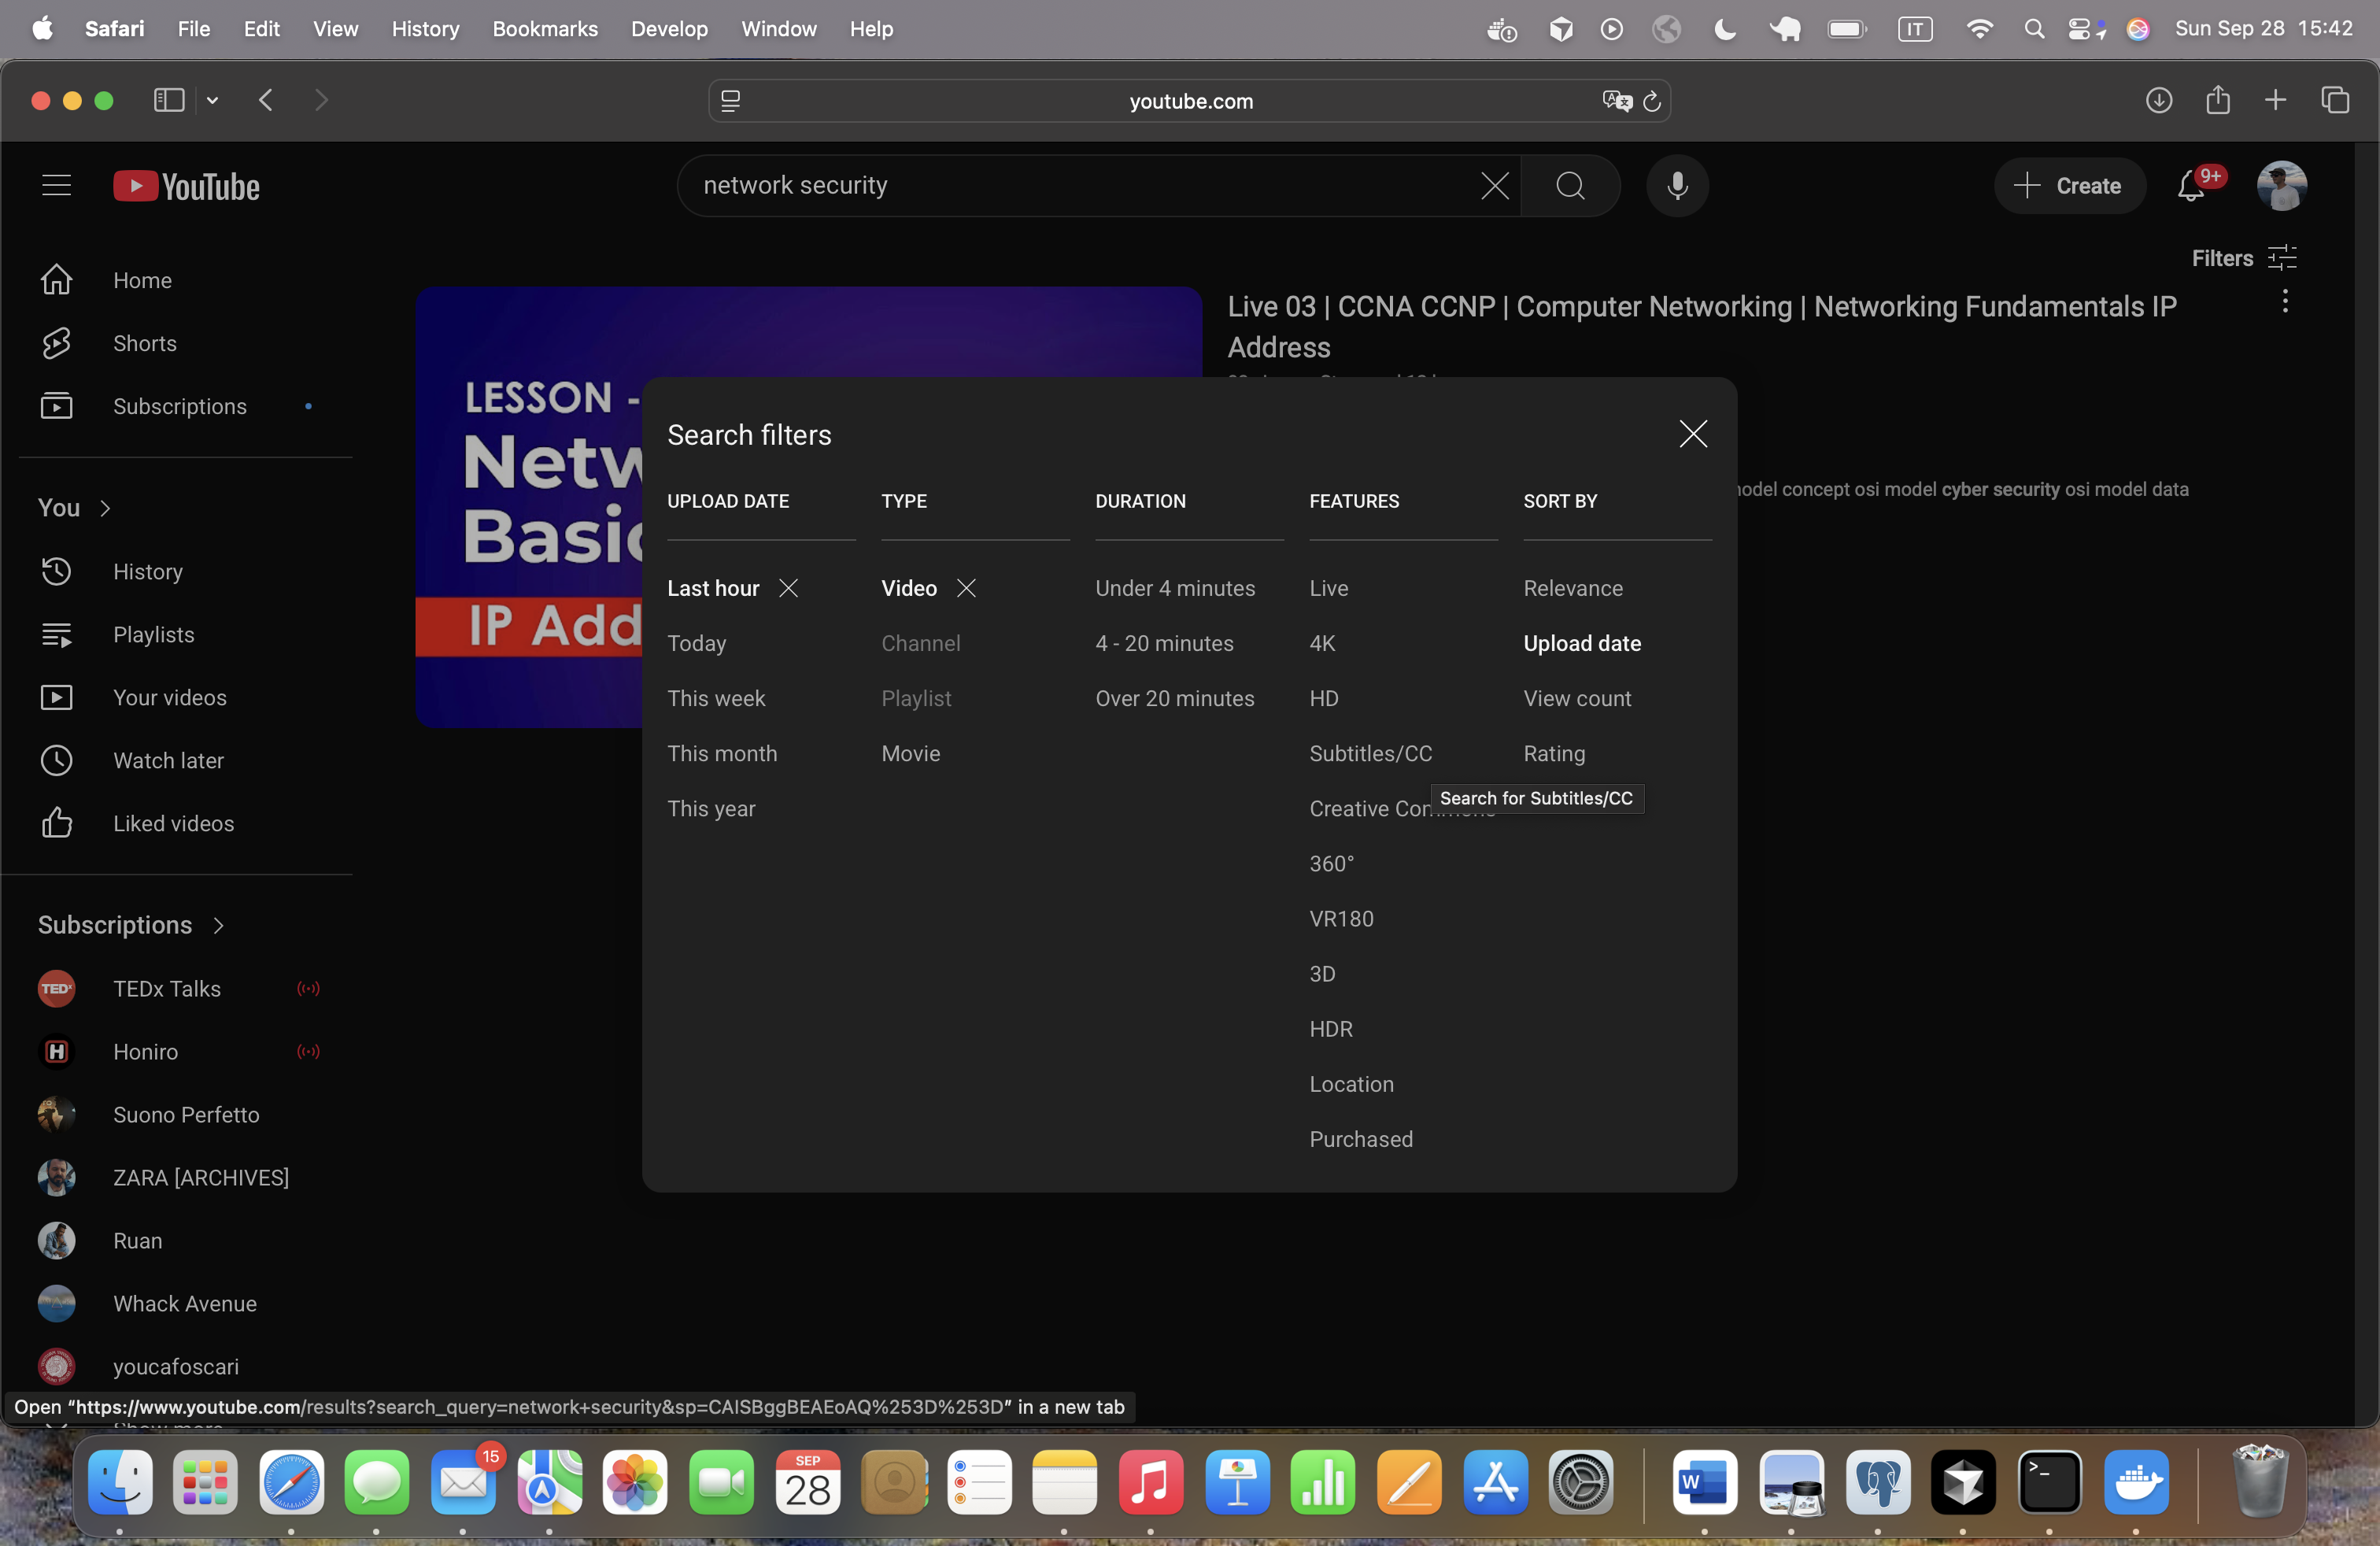
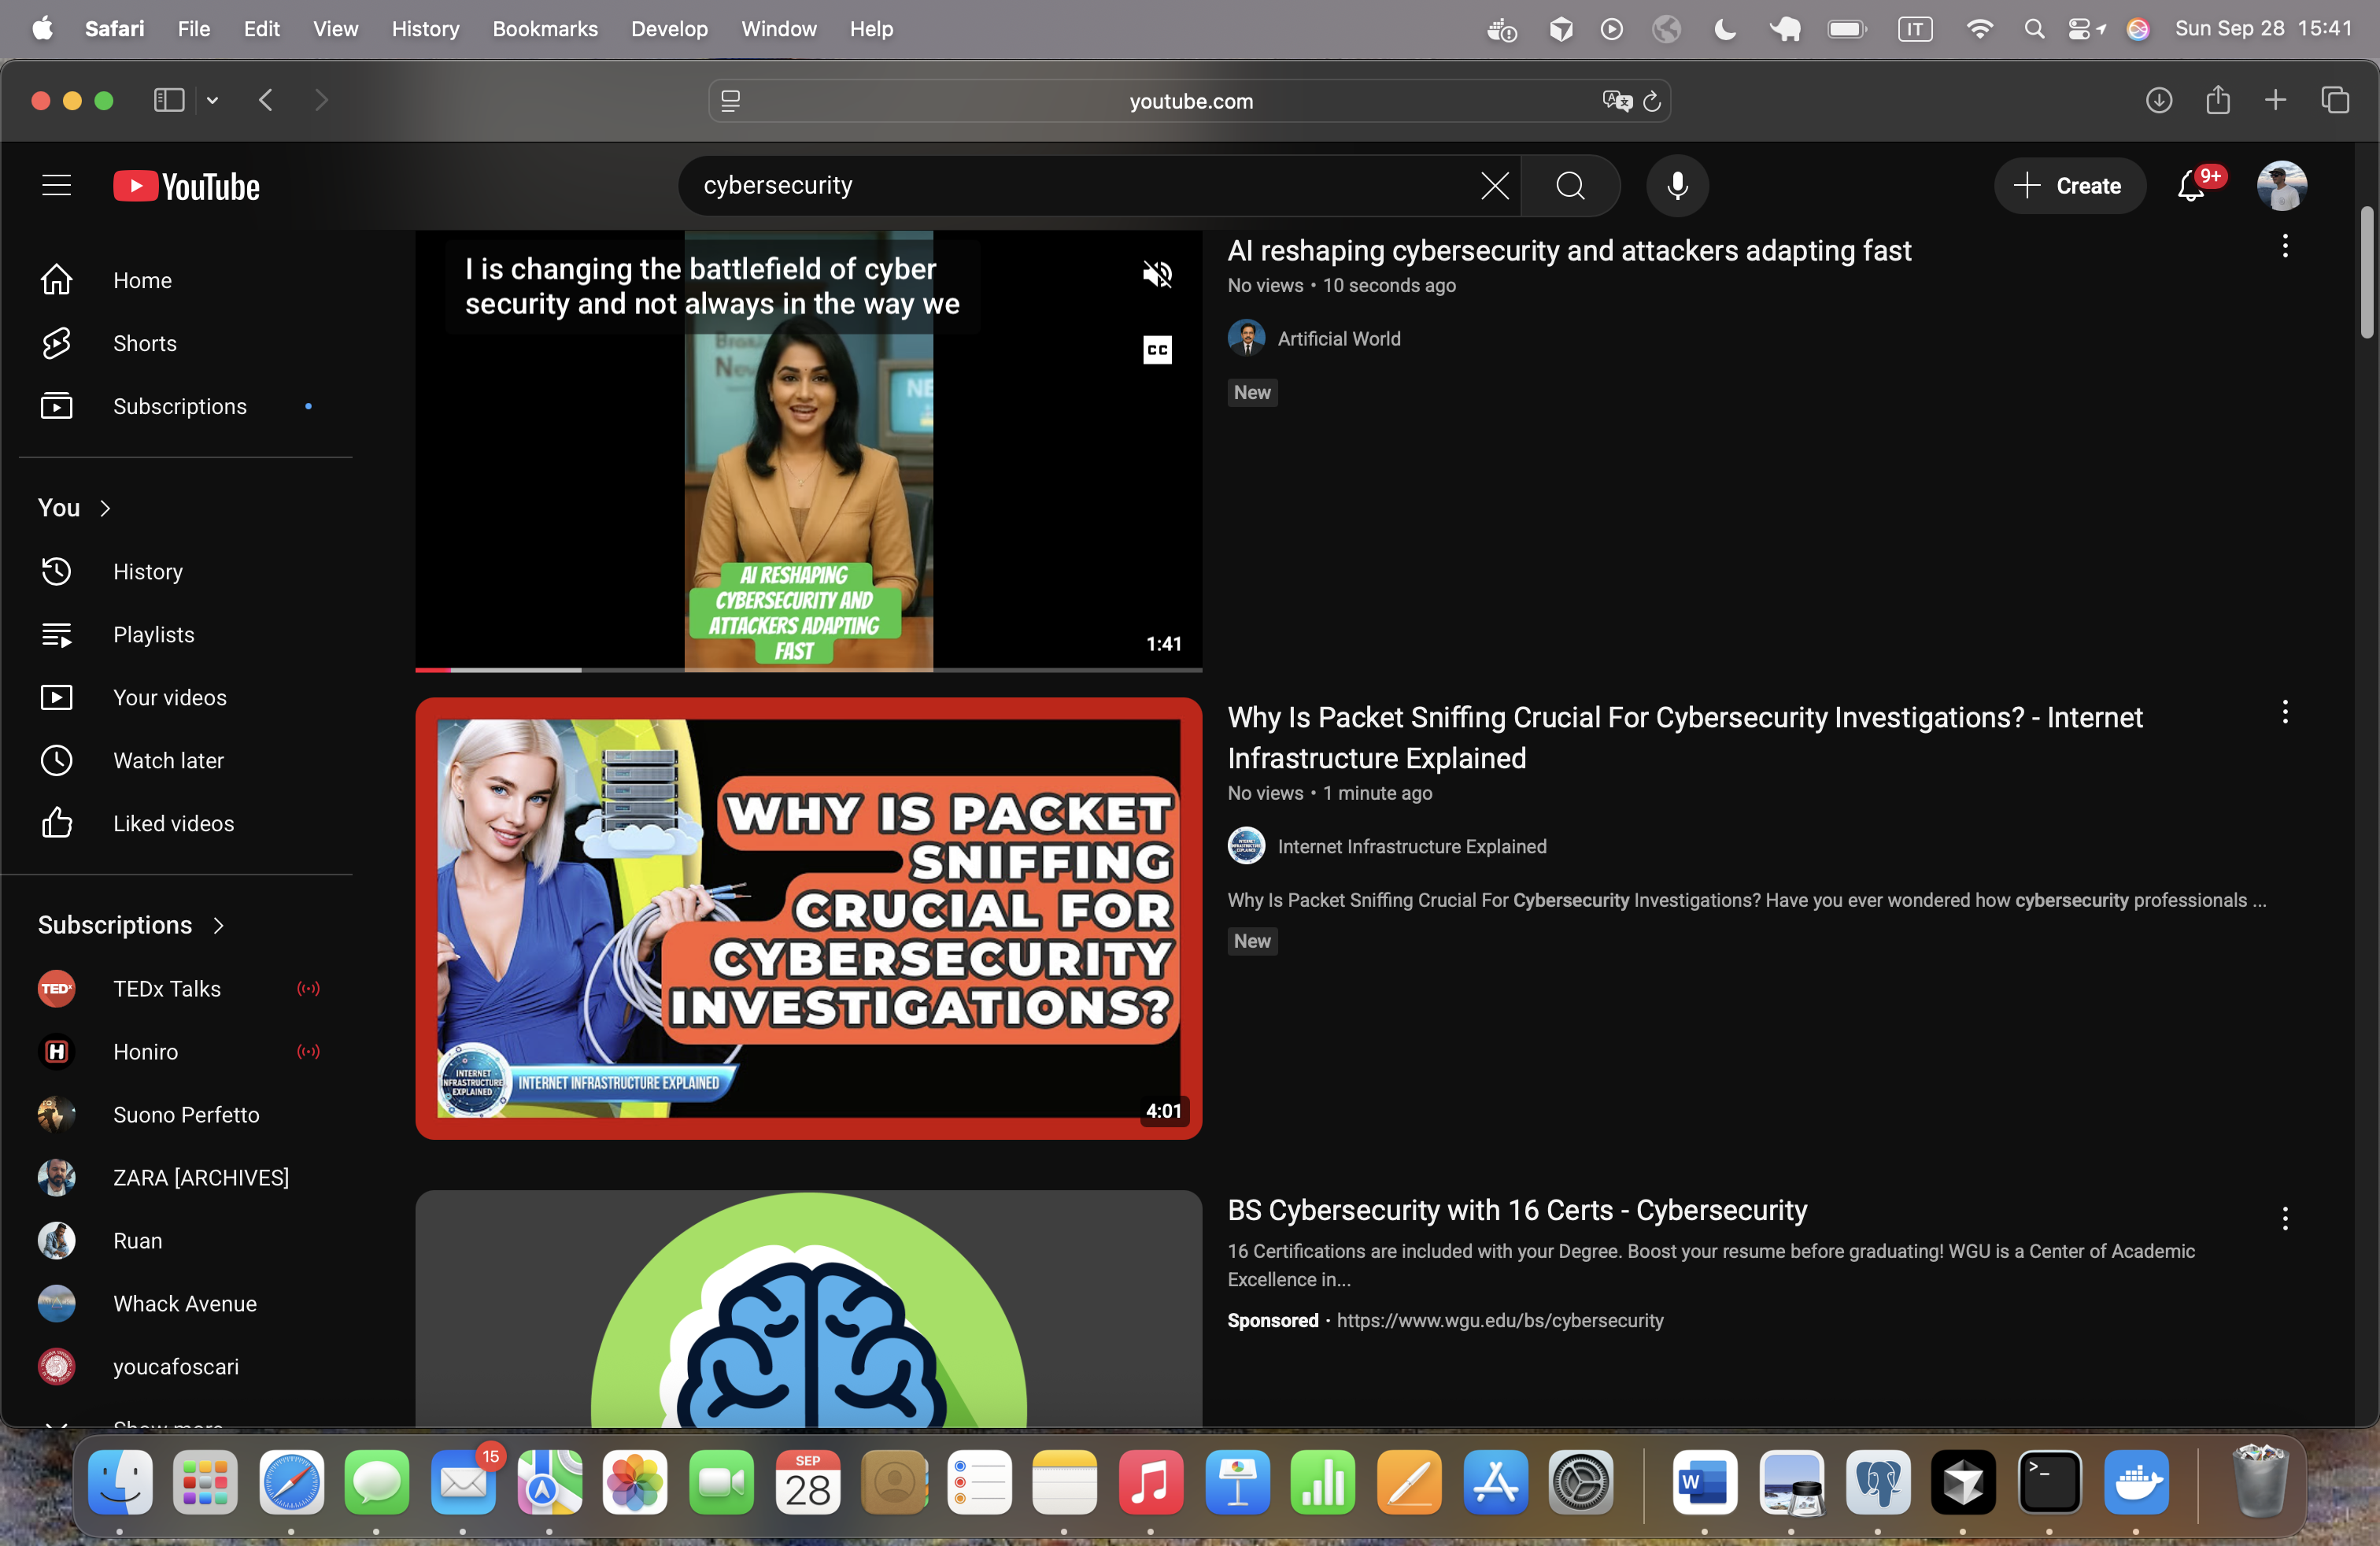
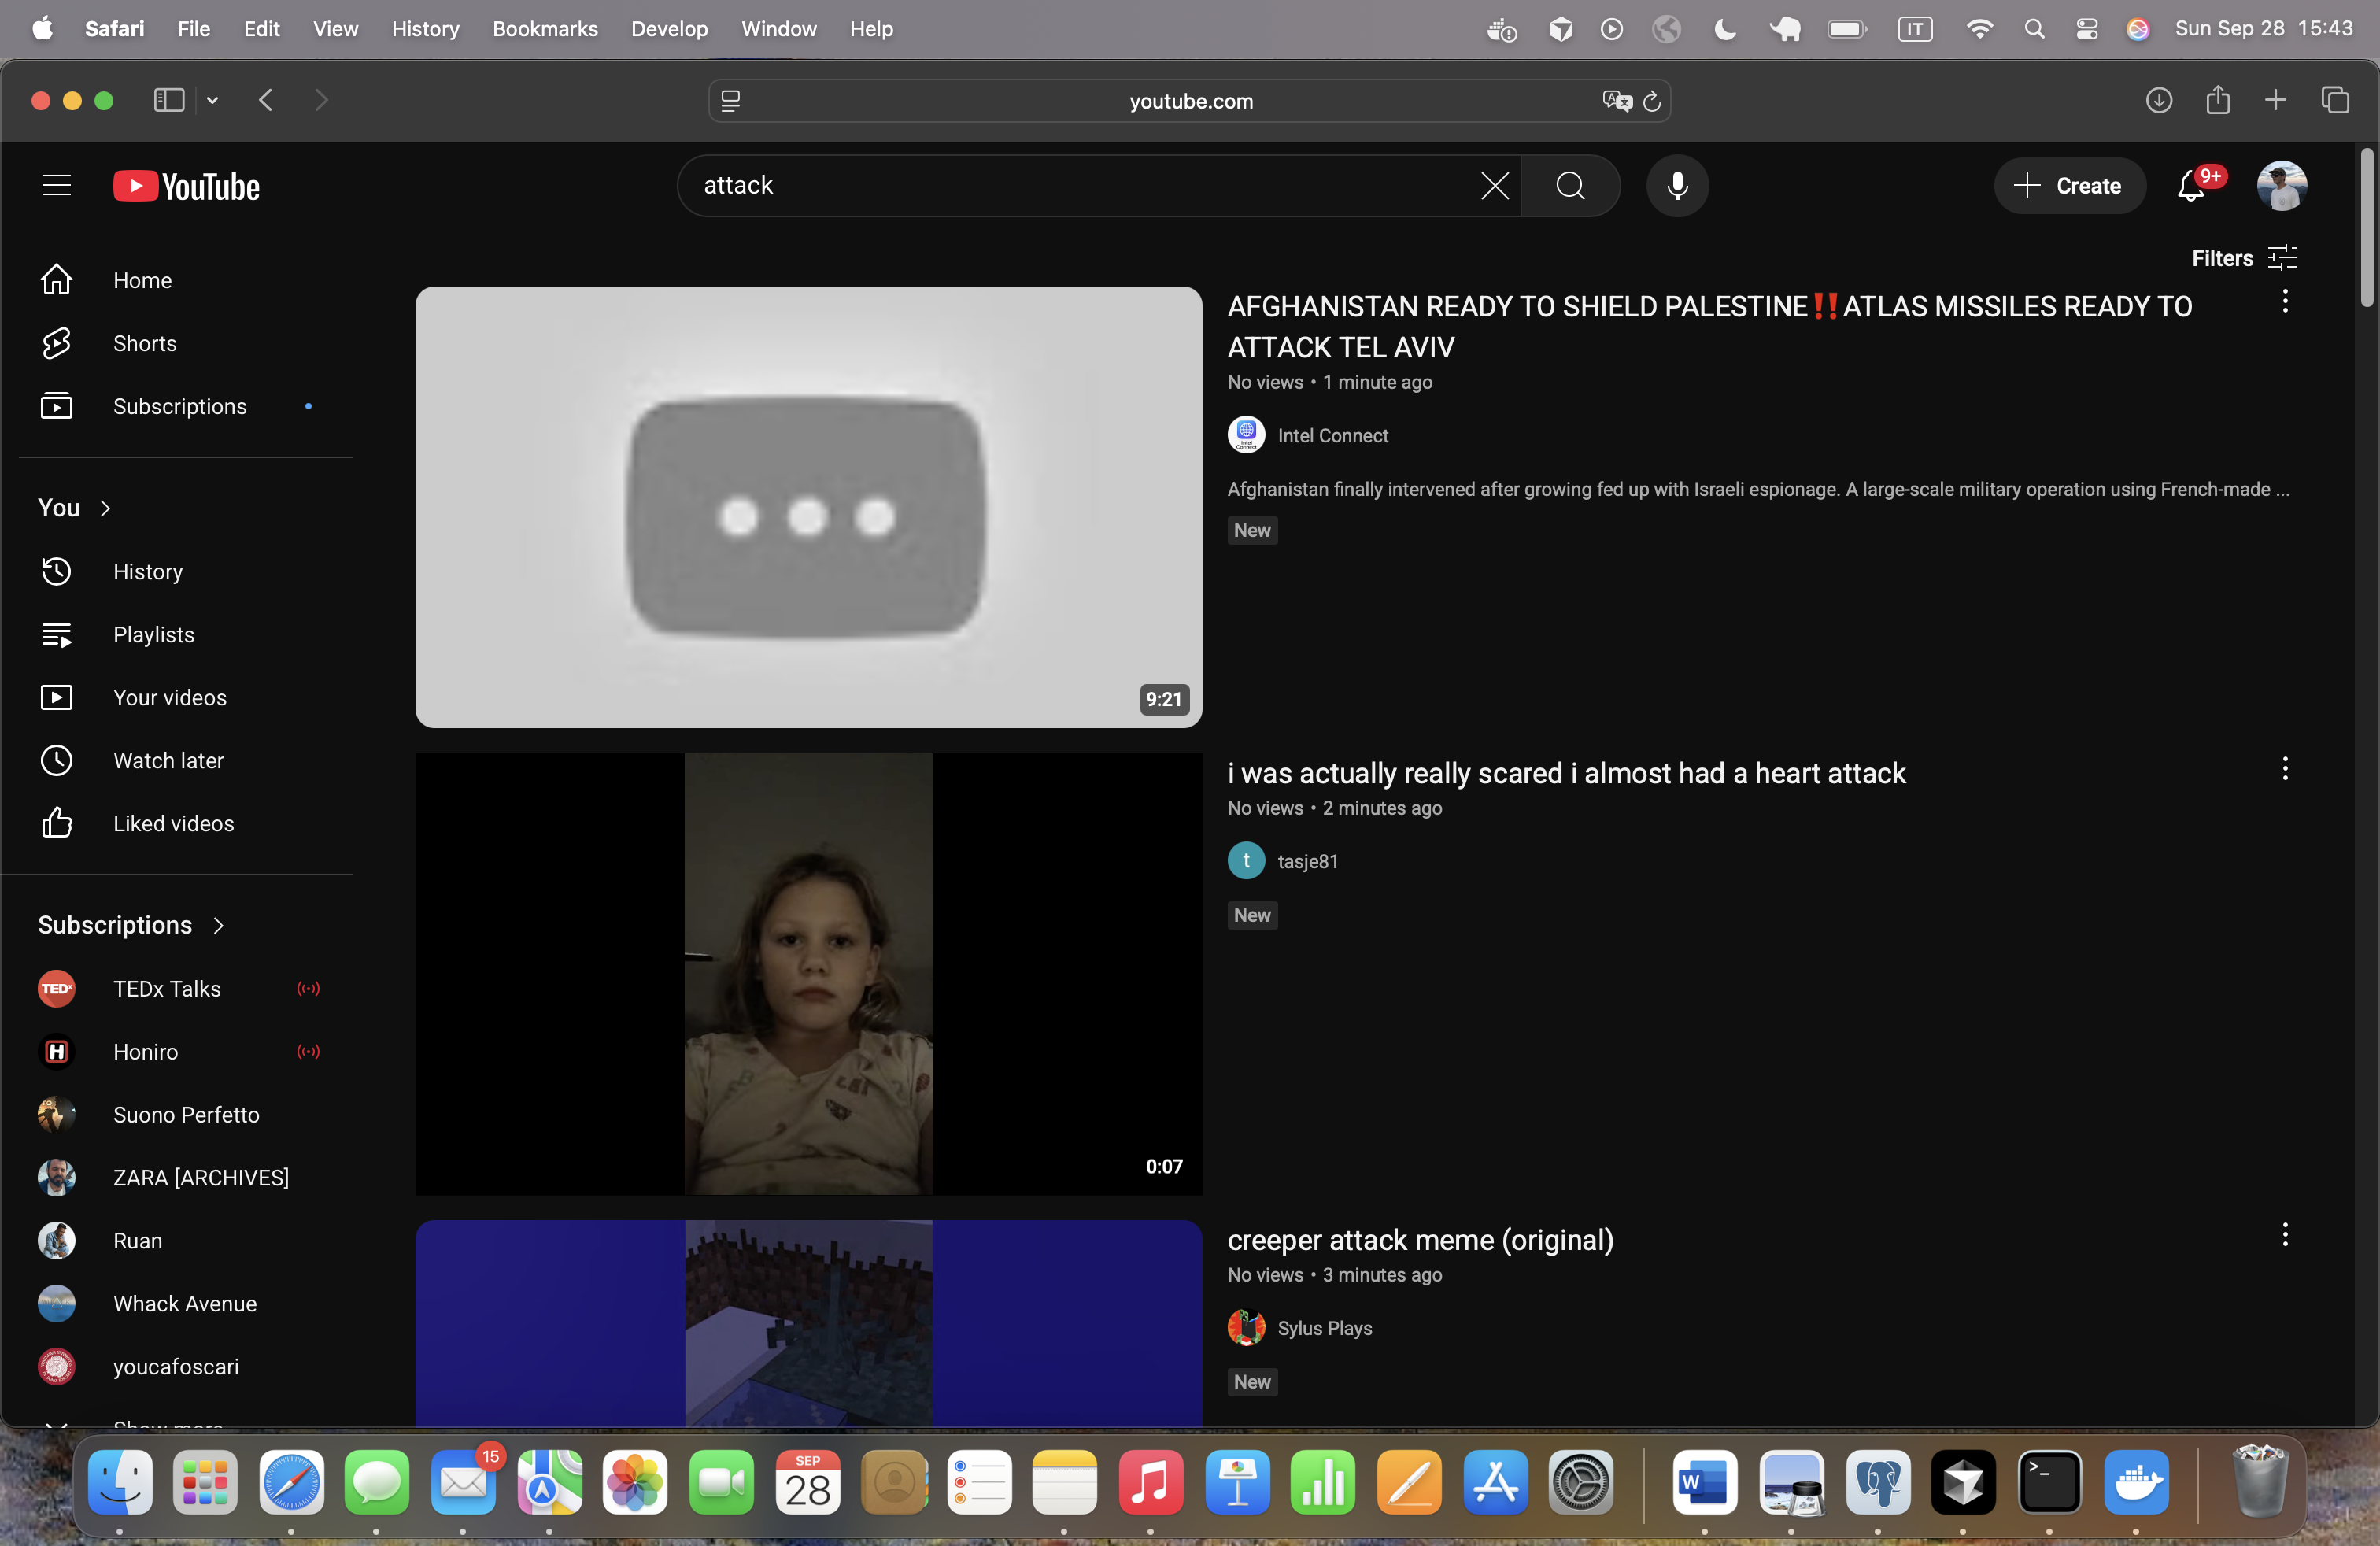

TASK III

In [4]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

from pyspark.ml.classification import LogisticRegression

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np
import pandas as pd
from pyspark.ml.classification import RandomForestClassifier


nominal_cols = ["tcp_flags", "mqtt_hdrflags", "mqtt_msg", "mqtt_conack_flags"]
binary_cols = ["mqtt_dupflag"]
continuous_cols = ["tcp_time_delta", "tcp_len", "mqtt_len", "mqtt_msgid", "mqtt_qos"]

df_train_raw = df_train
df_test_raw = df_test

for col_name in df_train_raw.columns:  
    df_train_raw = df_train_raw.withColumnRenamed(col_name, col_name.replace(".", "_"))

for col_name in df_test_raw.columns:
    df_test_raw = df_test_raw.withColumnRenamed(col_name, col_name.replace(".", "_"))


In [19]:
#We first perform an exploratory check, to make sure no NaN values are present in the data and to visualize the correlation among the features
df_train_raw.printSchema()
df_train_raw.show(1)

null_counts_df = df_train_raw.select([count(when(col(c).isNull(), c)).alias(c) for c in nominal_cols + binary_cols + continuous_cols])
null_counts_df.show(truncate=False, vertical=True)

numeric_cols = binary_cols + continuous_cols
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features_vec", handleInvalid="skip")
df_vec = assembler.transform(df_train_raw).select("features_vec")
corr_matrix = Correlation.corr(df_vec, "features_vec", method="pearson").collect()[0][0]
#print(corr_matrix.toArray())

corr_array = np.array(corr_matrix.toArray())

col_names = [c.replace("`", "") for c in numeric_cols]
corr_df = pd.DataFrame(corr_array, columns=col_names, index=col_names)
print(corr_df.round(3))

root
 |-- tcp_flags: string (nullable = true)
 |-- tcp_time_delta: double (nullable = true)
 |-- tcp_len: integer (nullable = true)
 |-- mqtt_conack_flags: string (nullable = true)
 |-- mqtt_conack_flags_reserved: double (nullable = true)
 |-- mqtt_conack_flags_sp: double (nullable = true)
 |-- mqtt_conack_val: double (nullable = true)
 |-- mqtt_conflag_cleansess: double (nullable = true)
 |-- mqtt_conflag_passwd: double (nullable = true)
 |-- mqtt_conflag_qos: double (nullable = true)
 |-- mqtt_conflag_reserved: double (nullable = true)
 |-- mqtt_conflag_retain: double (nullable = true)
 |-- mqtt_conflag_uname: double (nullable = true)
 |-- mqtt_conflag_willflag: double (nullable = true)
 |-- mqtt_conflags: string (nullable = true)
 |-- mqtt_dupflag: double (nullable = true)
 |-- mqtt_hdrflags: string (nullable = true)
 |-- mqtt_kalive: double (nullable = true)
 |-- mqtt_len: double (nullable = true)
 |-- mqtt_msg: string (nullable = true)
 |-- mqtt_msgid: double (nullable = true)
 |-

-RECORD 0----------------
 tcp_flags         | 0   
 mqtt_hdrflags     | 0   
 mqtt_msg          | 0   
 mqtt_conack_flags | 0   
 mqtt_dupflag      | 0   
 tcp_time_delta    | 0   
 tcp_len           | 0   
 mqtt_len          | 0   
 mqtt_msgid        | 0   
 mqtt_qos          | 0   



[Stage 48:====================================>                  (64 + 32) / 96]

                mqtt_dupflag  tcp_time_delta  tcp_len  mqtt_len  mqtt_msgid  \
mqtt_dupflag           1.000          -0.011   -0.012     0.526       0.433   
tcp_time_delta        -0.011           1.000    0.042    -0.015      -0.025   
tcp_len               -0.012           0.042    1.000     0.039      -0.036   
mqtt_len               0.526          -0.015    0.039     1.000       0.597   
mqtt_msgid             0.433          -0.025   -0.036     0.597       1.000   
mqtt_qos               0.578          -0.020   -0.022     0.909       0.667   

                mqtt_qos  
mqtt_dupflag       0.578  
tcp_time_delta    -0.020  
tcp_len           -0.022  
mqtt_len           0.909  
mqtt_msgid         0.667  
mqtt_qos           1.000  


From this exploratory check, we immediately find that a significant number of columns have NaN correlations. Therefore, since we have confirmed there are no NaN values in the dataset, these columns must have a variance of 0, meaning they are meaningless for our task. In addition, we will also drop mqtt.conflag.uname, mqtt.proto_len, mqtt.ver as they show a correlation greater than 0.8. On the other hand, mqtt.qos was kept as it was kept in the paper asswell

In [5]:
class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name, col(col_name).cast(DoubleType()))
        return output_df

class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop = columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            if col_name in output_df.columns:
                output_df = output_df.drop(col_name)
        return output_df
        

def get_preprocess_pipeline():

    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x + "_index" for x in nominal_cols]

    # we need the target to be indexed given the multiclass nature of the problem
    stage_target_indexer = StringIndexer(inputCol="target", outputCol="target_index", handleInvalid="keep")
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols, handleInvalid="keep")
    # with handleInvalid="keep", we handle the case where a categorical variable appears in a validation fold during cross validation but was not present in that fold's training split. (Source ChatGPT)

    # no need of imputer since there are no NaN values

    # Stage where all relevant features are assembled into a vector
    feature_cols = continuous_cols + binary_cols + nominal_id_cols

    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol='vectorized_features', outputCol='features')

    # Removing all unnecessary columns, only keeping the 'features' and 'target_index' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols + nominal_id_cols + binary_cols + continuous_cols + ['vectorized_features'])

    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[
        stage_typecaster,
        stage_target_indexer,
        stage_nominal_indexer,
        stage_vector_assembler,
        stage_scaler,
        stage_column_dropper
    ])

    return pipeline


As a disclaimer, all the following models were tested and tuned using only 1% (fraction=0.01) of the full dataset. This choice was made because the parameter tuning was performed locally on my laptop, and running it on the entire dataset would have taken an impractically long time. Moreover, the data seems to be quite uniform, as after several trials with different randomly selected samples, the difference between training and validation accuracy remained minimal. 

In [21]:
df_train_sample = df_train_raw.sample(fraction=0.01)
df_test_sample = df_test_raw.sample(fraction=0.01)

pipeline = get_preprocess_pipeline()
preprocessed_df = pipeline.fit(df_train_sample).transform(df_train_sample)

first_feature_vector = preprocessed_df.select("features").collect()[0][0]

print(f"Dim 'features': {first_feature_vector.size}")


Dim 'features': 10


In [22]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np

df_train_sample = df_train_raw.sample(fraction=0.001)
df_test_sample = df_test_raw.sample(fraction=0.001)

preprocess_pipeline_sample = get_preprocess_pipeline()
preprocess_pipeline_model_sample = preprocess_pipeline_sample.fit(df_train_sample)

df_train_trans_sample = preprocess_pipeline_model_sample.transform(df_train_sample)
df_test_trans_sample = preprocess_pipeline_model_sample.transform(df_test_sample)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='target_index',
    family="multinomial"
)

param_grid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [50, 100, 200]) \
    .addGrid(lr.regParam, [0.0001, 0.001, 0.01, 0.1]) \
    .build()

best_accuracy = 0
best_params = None

for params in param_grid:
    lr_model = lr.copy(params).fit(df_train_trans_sample)
    lr_prediction_train = lr_model.transform(df_train_trans_sample)
    lr_prediction_test = lr_model.transform(df_test_trans_sample)
    
    lr_accuracy_test = (lr_prediction_test.filter(lr_prediction_test.target_index == lr_prediction_test.prediction)
        .count() / float(lr_prediction_test.count()))
    if lr_accuracy_test > best_accuracy:
        best_accuracy = lr_accuracy_test
        best_params = params

print(f"maxIter: {best_params[lr.maxIter]}")
print(f"regParam: {best_params[lr.regParam]}")
print(f"Accuracy: {np.round(best_accuracy*100,2)}%")

maxIter: 50
regParam: 0.0001
Accuracy: 68.27%


In [7]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark import StorageLevel

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(df_train_raw)

df_train_trans = preprocess_pipeline_model.transform(df_train_raw)
df_test_trans = preprocess_pipeline_model.transform(df_test_raw)


lr = LogisticRegression(
    featuresCol='features',
    labelCol='target_index',
    maxIter=50,
    regParam=0.0001,
    family="multinomial"
)

lr_model = lr.fit(df_train_trans)

lr_prediction_train = lr_model.transform(df_train_trans)
lr_prediction_test = lr_model.transform(df_test_trans)

lr_accuracy_train = (lr_prediction_train.filter(lr_prediction_train.target_index == lr_prediction_train.prediction)
    .count() / float(lr_prediction_train.count()))
lr_accuracy_test = (lr_prediction_test.filter(lr_prediction_test.target_index == lr_prediction_test.prediction)
    .count() / float(lr_prediction_test.count()))

print(f"LR - Train accuracy = {np.round(lr_accuracy_train*100,2)}%, test accuracy = {np.round(lr_accuracy_test*100,2)}%")


LR - Train accuracy = 67.97%, test accuracy = 67.97%


In [24]:
from xgboost.spark import SparkXGBClassifier

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(df_train_raw)

df_train_trans = preprocess_pipeline_model.transform(df_train_raw)
df_test_trans = preprocess_pipeline_model.transform(df_test_raw)

xgb = SparkXGBClassifier(
    features_col='features',
    label_col='target_index',
    num_workers=32,
    max_depth=5,
    n_estimators=20,
    tree_method='hist',
)

xgb_model = xgb.fit(df_train_trans)

xgb_prediction_train = xgb_model.transform(df_train_trans)
xgb_prediction_test = xgb_model.transform(df_test_trans)

xgb_accuracy_train = (xgb_prediction_train.filter(xgb_prediction_train.target_index == xgb_prediction_train.prediction)
    .count() / float(xgb_prediction_train.count()))
xgb_accuracy_test = (xgb_prediction_test.filter(xgb_prediction_test.target_index == xgb_prediction_test.prediction)
    .count() / float(xgb_prediction_test.count()))

print(f"XGBoost - Train accuracy = {np.round(xgb_accuracy_train*100,2)}%, test accuracy = {np.round(xgb_accuracy_test*100,2)}%")


INFO:XGBoost-PySpark:Running xgboost-3.1.1 on 32 workers with                   
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'max_depth': 5, 'tree_method': 'hist', 'num_class': 6, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 20}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-12 04:47:34,197 INFO XGBoost-PySpark: _train_booster Training on CPUs32]
[04:47:37] Task 12 got rank 4
[04:47:37] Task 11 got rank 3
[04:47:37] Task 14 got rank 6
[04:47:37] Task 15 got rank 7[04:47:37] Task 17 got rank 9

[04:47:37] Task 16 got rank 8[04:47:37] Task 0 got rank 0

[04:47:37] Task 19 got rank 11
[04:47:37] Task 2 got rank 12
[04:47:37] Task 1 got rank 1
[04:47:37] Task 18 got rank 10
[04:47:37] Task 10 got rank 2
[04:47:37] Task 22 got rank 15
[04:47:37] Task 23 got rank 16
[04:47:37] Task 24 got rank 17
[04:47:37] Task 25 got rank 18
[04:47:37] Task 26 got rank 19
[04:47:37] Task 27 got rank 20
[04:47:37] Task 21 got rank 14
[04:4

XGBoost - Train accuracy = 90.28%, test accuracy = 90.31%


In [21]:

from torch.utils.data import DataLoader, TensorDataset
import torch
import numpy as np

df_train_sample = df_train_raw
df_test_sample = df_test_raw

df_validate_sample, df_test_sample = df_test_sample.randomSplit([0.5, 0.5])

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(df_train_sample)

df_train_trans = preprocess_pipeline_model.transform(df_train_sample)
df_validate_trans = preprocess_pipeline_model.transform(df_validate_sample)
df_test_trans = preprocess_pipeline_model.transform(df_test_sample)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
print(f"Train dataset: {df_train_trans.count()}")
print(f"Validate dataset: {df_validate_trans.count()}")
print(f"Test dataset: {df_test_trans.count()}")

Train dataset: 14000000


Validate dataset: 2999387


[Stage 270:====================================>                 (64 + 32) / 96]

Test dataset: 3000613


In [22]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.cuda.memory_allocated())

True
Tesla T4
1091271168


In [23]:
import torch
import numpy as np
import builtins
import warnings
warnings.filterwarnings("ignore")

def spark_vectors_to_numpy(spark_df):
    rdd = spark_df.rdd.map(lambda row: (
        np.array(row['features'].toArray(), dtype=np.float32),
        int(row['target_index'])
    ))
    data = rdd.collect()
    X = np.array([d[0] for d in data], dtype=np.float32)
    y = np.array([d[1] for d in data], dtype=np.int64)
    return X, y

train_X_np, train_y_np = spark_vectors_to_numpy(df_train_trans)
val_X_np, val_y_np = spark_vectors_to_numpy(df_validate_trans)
test_X_np, test_y_np = spark_vectors_to_numpy(df_test_trans)

print(f"Train: {train_X_np.shape}")
print(f"Val: {val_X_np.shape}")
print(f"Test: {test_X_np.shape}\n")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_X = torch.from_numpy(train_X_np).to(device, non_blocking=True)
train_y = torch.from_numpy(train_y_np).to(device, non_blocking=True)

val_X = torch.from_numpy(val_X_np).to(device, non_blocking=True)
val_y = torch.from_numpy(val_y_np).to(device, non_blocking=True)

test_X = torch.from_numpy(test_X_np).to(device, non_blocking=True)
test_y = torch.from_numpy(test_y_np).to(device, non_blocking=True)

torch.cuda.synchronize()

Train: (14000000, 10)
Val: (3002161, 10)
Test: (2997839, 10)



start train
Epoch 0, Train accuracy: 66.10%, validate accuracy: 72.43%, time= 0.8s
Epoch 1, Train accuracy: 73.41%, validate accuracy: 73.86%, time= 0.7s
Epoch 2, Train accuracy: 73.85%, validate accuracy: 73.93%, time= 0.7s
Epoch 3, Train accuracy: 73.89%, validate accuracy: 73.89%, time= 0.7s
Epoch 4, Train accuracy: 73.92%, validate accuracy: 73.96%, time= 0.7s
Epoch 5, Train accuracy: 73.97%, validate accuracy: 74.23%, time= 0.7s
Epoch 6, Train accuracy: 74.10%, validate accuracy: 74.27%, time= 0.7s
Epoch 7, Train accuracy: 74.17%, validate accuracy: 74.27%, time= 0.7s
Epoch 8, Train accuracy: 74.17%, validate accuracy: 74.23%, time= 0.7s
Epoch 9, Train accuracy: 74.23%, validate accuracy: 74.20%, time= 0.7s
Epoch 10, Train accuracy: 74.23%, validate accuracy: 74.26%, time= 0.7s
Epoch 11, Train accuracy: 74.25%, validate accuracy: 74.20%, time= 0.7s
Epoch 12, Train accuracy: 74.25%, validate accuracy: 74.30%, time= 0.7s
Epoch 13, Train accuracy: 74.25%, validate accuracy: 74.27%, t

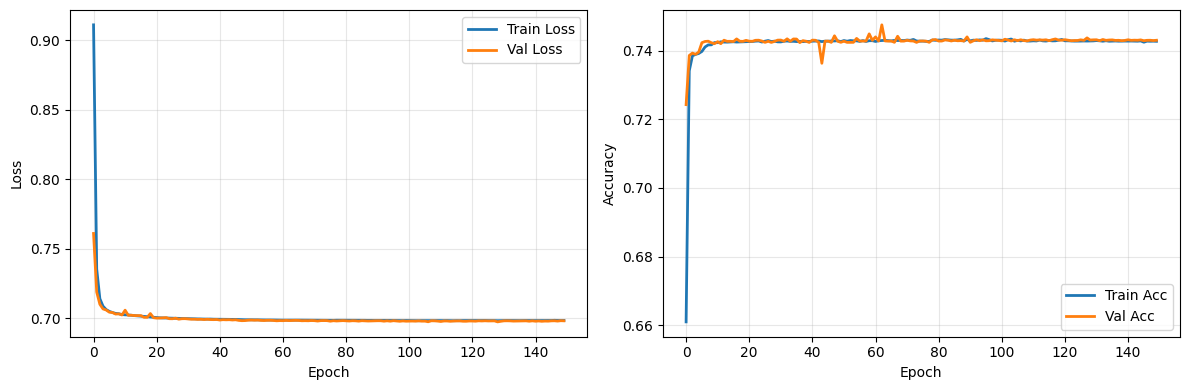

In [24]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import warnings
import time
import builtins
from torch.optim.lr_scheduler import ExponentialLR
warnings.filterwarnings("ignore")


batch_size = 64192
lr = 0.01
N_epochs = 150


class nnAttackType_Shallow(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, output_size)
        )
    
    def forward(self, x):
        return self.layers(x)

input_size = train_X.shape[1]
output_size = builtins.len(np.unique(train_y_np))

model = nnAttackType_Shallow(input_size, output_size).to(device)

loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = ExponentialLR(optimizer, gamma=0.95)

losses, accuracies = [], []
validate_losses, validate_accuracies = [], []
current_best_accuracy = 0.0
best_val_loss = float('inf')

scaler = torch.cuda.amp.GradScaler()

print("start train")

n_train_batches = (builtins.len(train_X) + batch_size - 1) // batch_size
n_val_batches = (builtins.len(val_X) + batch_size - 1) // batch_size

train_indices = torch.arange(builtins.len(train_X), device=device)

for epoch in range(N_epochs):
    train_indices = train_indices[torch.randperm(builtins.len(train_indices), device=device)]
    
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    epoch_start = time.time()
    
    for batch_idx in range(n_train_batches):
        start = batch_idx * batch_size
        end = builtins.min(start + batch_size, builtins.len(train_X))
        
        batch_indices = train_indices[start:end]
        x_batch = train_X[batch_indices]
        y_batch = train_y[batch_indices]
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast(dtype=torch.float16):
            prediction_score = model(x_batch)
            loss = loss_fun(prediction_score, y_batch)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item() * y_batch.size(0)
        prediction_label = prediction_score.argmax(dim=1)
        train_correct += (prediction_label == y_batch).sum().item()
        train_total += y_batch.size(0)
    
    avg_train_loss = train_loss / train_total
    avg_train_acc = train_correct / train_total
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_idx in range(n_val_batches):
            start = batch_idx * batch_size
            end = builtins.min(start + batch_size, builtins.len(val_X))
            
            x_batch = val_X[start:end]
            y_batch = val_y[start:end]
            
            with torch.cuda.amp.autocast(dtype=torch.float16):
                prediction_score = model(x_batch)
                loss = loss_fun(prediction_score, y_batch)
            
            val_loss += loss.item() * y_batch.size(0)
            prediction_label = prediction_score.argmax(dim=1)
            val_correct += (prediction_label == y_batch).sum().item()
            val_total += y_batch.size(0)
    
    avg_val_loss = val_loss / val_total
    avg_val_acc = val_correct / val_total
    
    scheduler.step()
    
    losses.append(avg_train_loss)
    accuracies.append(avg_train_acc)
    validate_losses.append(avg_val_loss)
    validate_accuracies.append(avg_val_acc)
    
    epoch_time = time.time() - epoch_start
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch}, Train accuracy: {avg_train_acc*100:5.2f}%, validate accuracy: {avg_val_acc*100:5.2f}%, time= {epoch_time:.1f}s")

    if avg_val_acc > current_best_accuracy:
        torch.save(model.state_dict(), 'current_best_model_shallow.pt')
        current_best_accuracy = avg_val_acc
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(losses, label='Train Loss', linewidth=2)
axes[0].plot(validate_losses, label='Val Loss', linewidth=2)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(accuracies, label='Train Acc', linewidth=2)
axes[1].plot(validate_accuracies, label='Val Acc', linewidth=2)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [25]:
import torch
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_model = nnAttackType_Shallow(input_size=train_X.shape[1], output_size=len(torch.unique(train_y)))
best_model.load_state_dict(torch.load("current_best_model_shallow.pt", map_location=device))
best_model = best_model.to(device).eval()

batch_size_test = 64192
n_test_batches = (len(test_X) + batch_size_test - 1) // batch_size_test
test_accuracies = []

with torch.no_grad():
    for i in range(n_test_batches):
        start_idx = i * batch_size_test
        end_idx = start_idx + batch_size_test
        if end_idx > len(test_X):
            end_idx = len(test_X)
        x_batch = test_X[start_idx:end_idx]
        y_batch = test_y[start_idx:end_idx]
        pred_labels = best_model(x_batch).argmax(dim=1)
        test_accuracies.append((pred_labels == y_batch).float().mean().item())

print(f"Test accuracy = {np.mean(test_accuracies)*100:.2f}%")


Test accuracy = 74.28%


start train
Epoch 0, Train accuracy: 71.41%, validate accuracy: 74.10%, time= 1.5s
Epoch 1, Train accuracy: 73.75%, validate accuracy: 72.78%, time= 1.4s
Epoch 2, Train accuracy: 73.86%, validate accuracy: 73.24%, time= 1.4s
Epoch 3, Train accuracy: 74.21%, validate accuracy: 74.19%, time= 1.4s
Epoch 4, Train accuracy: 74.32%, validate accuracy: 74.36%, time= 1.4s
Epoch 5, Train accuracy: 72.72%, validate accuracy: 73.94%, time= 1.4s
Epoch 6, Train accuracy: 74.08%, validate accuracy: 74.28%, time= 1.4s
Epoch 7, Train accuracy: 74.29%, validate accuracy: 74.32%, time= 1.4s
Epoch 8, Train accuracy: 74.29%, validate accuracy: 74.34%, time= 1.4s
Epoch 9, Train accuracy: 74.31%, validate accuracy: 74.36%, time= 1.4s
Epoch 10, Train accuracy: 74.34%, validate accuracy: 74.37%, time= 1.4s
Epoch 11, Train accuracy: 74.32%, validate accuracy: 74.34%, time= 1.4s
Epoch 12, Train accuracy: 74.32%, validate accuracy: 74.32%, time= 1.4s
Epoch 13, Train accuracy: 74.33%, validate accuracy: 74.55%, t

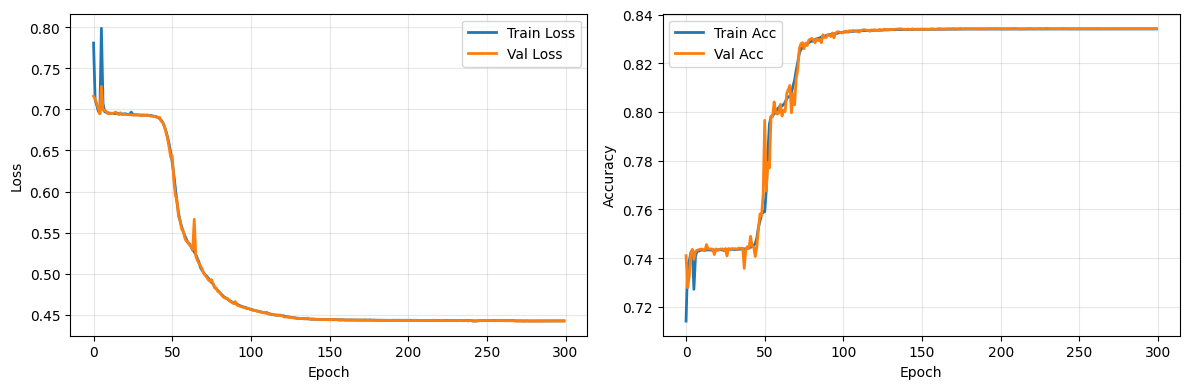

In [26]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import warnings
import time
import builtins
from torch.optim.lr_scheduler import ExponentialLR
warnings.filterwarnings("ignore")


batch_size = 64192
lr = 0.01
N_epochs = 300


class nnAttackType_Deep(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )
    
    def forward(self, x):
        return self.layers(x)

input_size = train_X.shape[1]
output_size = builtins.len(np.unique(train_y_np))

model = nnAttackType_Deep(input_size, output_size).to(device)

loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = ExponentialLR(optimizer, gamma=0.95)

losses, accuracies = [], []
validate_losses, validate_accuracies = [], []
current_best_accuracy = 0.0
best_val_loss = float('inf')

scaler = torch.cuda.amp.GradScaler()

print("start train")

n_train_batches = (builtins.len(train_X) + batch_size - 1) // batch_size
n_val_batches = (builtins.len(val_X) + batch_size - 1) // batch_size

train_indices = torch.arange(builtins.len(train_X), device=device)

for epoch in range(N_epochs):
    train_indices = train_indices[torch.randperm(builtins.len(train_indices), device=device)]
    
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    epoch_start = time.time()
    
    for batch_idx in range(n_train_batches):
        start = batch_idx * batch_size
        end = builtins.min(start + batch_size, builtins.len(train_X))
        
        batch_indices = train_indices[start:end]
        x_batch = train_X[batch_indices]
        y_batch = train_y[batch_indices]
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast(dtype=torch.float16):
            prediction_score = model(x_batch)
            loss = loss_fun(prediction_score, y_batch)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item() * y_batch.size(0)
        prediction_label = prediction_score.argmax(dim=1)
        train_correct += (prediction_label == y_batch).sum().item()
        train_total += y_batch.size(0)
    
    avg_train_loss = train_loss / train_total
    avg_train_acc = train_correct / train_total
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_idx in range(n_val_batches):
            start = batch_idx * batch_size
            end = builtins.min(start + batch_size, builtins.len(val_X))
            
            x_batch = val_X[start:end]
            y_batch = val_y[start:end]
            
            with torch.cuda.amp.autocast(dtype=torch.float16):
                prediction_score = model(x_batch)
                loss = loss_fun(prediction_score, y_batch)
            
            val_loss += loss.item() * y_batch.size(0)
            prediction_label = prediction_score.argmax(dim=1)
            val_correct += (prediction_label == y_batch).sum().item()
            val_total += y_batch.size(0)
    
    avg_val_loss = val_loss / val_total
    avg_val_acc = val_correct / val_total
    
    scheduler.step()
    
    losses.append(avg_train_loss)
    accuracies.append(avg_train_acc)
    validate_losses.append(avg_val_loss)
    validate_accuracies.append(avg_val_acc)
    
    epoch_time = time.time() - epoch_start
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch {epoch}, Train accuracy: {avg_train_acc*100:5.2f}%, validate accuracy: {avg_val_acc*100:5.2f}%, time= {epoch_time:.1f}s")

    if avg_val_acc > current_best_accuracy:
        torch.save(model.state_dict(), 'current_best_model_deep.pt')
        current_best_accuracy = avg_val_acc
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(losses, label='Train Loss', linewidth=2)
axes[0].plot(validate_losses, label='Val Loss', linewidth=2)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(accuracies, label='Train Acc', linewidth=2)
axes[1].plot(validate_accuracies, label='Val Acc', linewidth=2)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [27]:
import torch
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_model = nnAttackType_Deep(input_size=train_X.shape[1], output_size=len(torch.unique(train_y)))
best_model.load_state_dict(torch.load("current_best_model_deep.pt", map_location=device))
best_model = best_model.to(device).eval()

batch_size_test = 64192
n_test_batches = (len(test_X) + batch_size_test - 1) // batch_size_test
test_accuracies = []

with torch.no_grad():
    for i in range(n_test_batches):
        start_idx = i * batch_size_test
        end_idx = start_idx + batch_size_test
        if end_idx > len(test_X):
            end_idx = len(test_X)
        x_batch = test_X[start_idx:end_idx]
        y_batch = test_y[start_idx:end_idx]
        pred_labels = best_model(x_batch).argmax(dim=1)
        test_accuracies.append((pred_labels == y_batch).float().mean().item())

print(f"Test accuracy = {np.mean(test_accuracies)*100:.2f}%")


Test accuracy = 83.39%
